In [42]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np
from matplotlib import pyplot as plt

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1-self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0) #cumulative product.
        
    def prepare_noise_schedule(self, mode='linear'):
        if mode=='linear':
            return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        if mode=='cos':
            #TODO : open ai cos schedule
            pass
        
    def noise_images(self, x, t):
        # Generate X_t in a single step as described in the paper
        # x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*e
        e = torch.randn_like(x)
        x_t = x*torch.sqrt(self.alpha_hat[t])[:, None, None, None] + torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]*e # ?
        return x_t, e
        
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        model.eval()
        # Algo 2 - Sampling
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i>1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1/torch.sqrt(alpha)*(x-((1-alpha)/torch.sqrt(1-alpha_hat))*predicted_noise)+torch.sqrt(beta)*noise
            model.train()
            x = (x.clamp(-1,1)+1)/2
            x = (x*255).type(torch.uint8)
            return x

In [44]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [45]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [46]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [47]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):
        #print(x.size())
        x = self.up(x)
        #print(x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [48]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

In [49]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [50]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [51]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

938


999it [01:09, 14.42it/s]                                                                       | 0/100 [00:00<?, ?it/s]


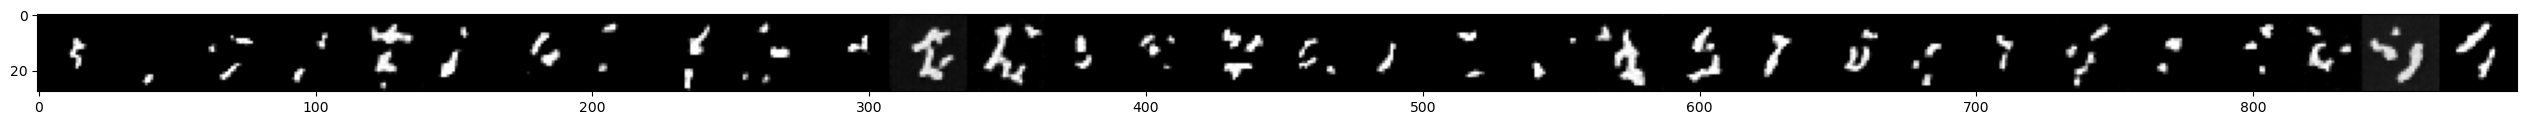

  1%|▊                                                                             | 1/100 [07:59<13:11:47, 479.88s/it]

Epoch [1/100] | Train Loss: 0.0722 | Validation Loss: 0.0378


  2%|█▌                                                                            | 2/100 [14:58<12:04:43, 443.71s/it]

Epoch [2/100] | Train Loss: 0.0332 | Validation Loss: 0.0306


  3%|██▎                                                                           | 3/100 [21:56<11:38:41, 432.18s/it]

Epoch [3/100] | Train Loss: 0.0301 | Validation Loss: 0.0291


999it [01:09, 14.28it/s]


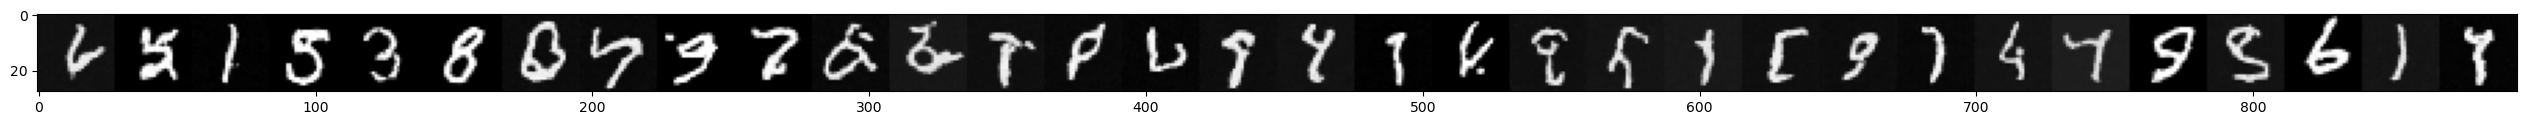

  4%|███                                                                           | 4/100 [30:05<12:07:05, 454.44s/it]

Epoch [4/100] | Train Loss: 0.0279 | Validation Loss: 0.0267


  5%|███▉                                                                          | 5/100 [37:04<11:39:09, 441.57s/it]

Epoch [5/100] | Train Loss: 0.0266 | Validation Loss: 0.0260


  6%|████▋                                                                         | 6/100 [44:03<11:19:51, 433.96s/it]

Epoch [6/100] | Train Loss: 0.0259 | Validation Loss: 0.0250


999it [01:10, 14.19it/s]


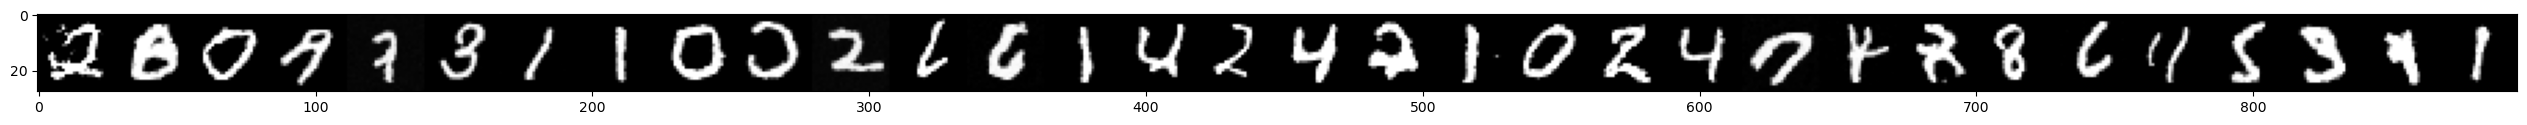

  7%|█████▍                                                                        | 7/100 [52:13<11:41:20, 452.48s/it]

Epoch [7/100] | Train Loss: 0.0255 | Validation Loss: 0.0240


  8%|██████▏                                                                       | 8/100 [59:13<11:17:57, 442.14s/it]

Epoch [8/100] | Train Loss: 0.0250 | Validation Loss: 0.0253


  9%|██████▊                                                                     | 9/100 [1:06:13<10:59:47, 435.03s/it]

Epoch [9/100] | Train Loss: 0.0245 | Validation Loss: 0.0247


999it [01:10, 14.23it/s]


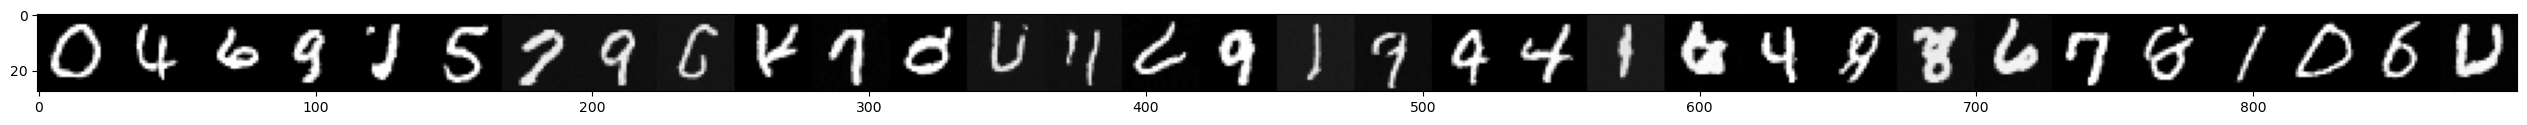

 10%|███████▌                                                                   | 10/100 [1:14:22<11:17:44, 451.83s/it]

Epoch [10/100] | Train Loss: 0.0242 | Validation Loss: 0.0233


 11%|████████▎                                                                  | 11/100 [1:21:22<10:55:30, 441.91s/it]

Epoch [11/100] | Train Loss: 0.0239 | Validation Loss: 0.0236


 12%|█████████                                                                  | 12/100 [1:28:21<10:38:09, 435.11s/it]

Epoch [12/100] | Train Loss: 0.0238 | Validation Loss: 0.0237


999it [01:10, 14.17it/s]


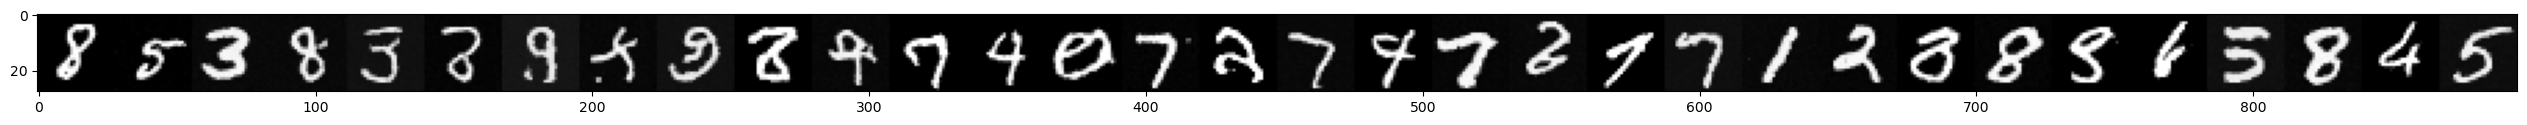

 13%|█████████▊                                                                 | 13/100 [1:36:32<10:55:22, 451.98s/it]

Epoch [13/100] | Train Loss: 0.0238 | Validation Loss: 0.0235


 14%|██████████▌                                                                | 14/100 [1:43:32<10:34:06, 442.40s/it]

Epoch [14/100] | Train Loss: 0.0233 | Validation Loss: 0.0231


 15%|███████████▎                                                               | 15/100 [1:50:33<10:17:17, 435.74s/it]

Epoch [15/100] | Train Loss: 0.0233 | Validation Loss: 0.0227


999it [01:10, 14.22it/s]


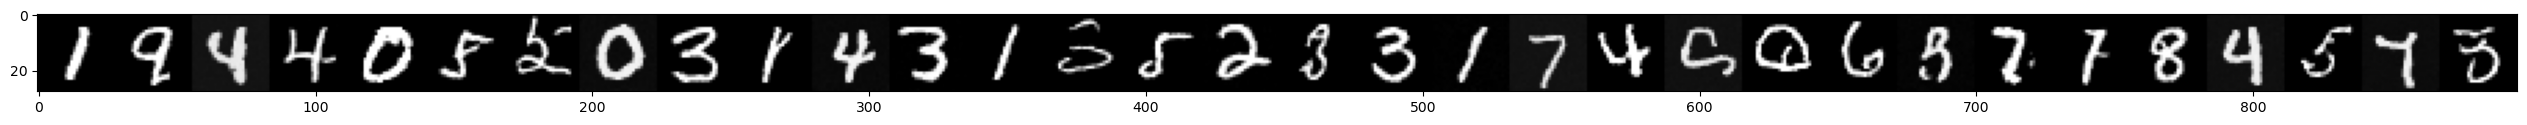

 16%|████████████                                                               | 16/100 [1:58:43<10:33:07, 452.23s/it]

Epoch [16/100] | Train Loss: 0.0229 | Validation Loss: 0.0235


 17%|████████████▊                                                              | 17/100 [2:05:44<10:12:30, 442.78s/it]

Epoch [17/100] | Train Loss: 0.0229 | Validation Loss: 0.0229


 18%|█████████████▋                                                              | 18/100 [2:12:44<9:55:55, 436.04s/it]

Epoch [18/100] | Train Loss: 0.0227 | Validation Loss: 0.0227


999it [01:10, 14.25it/s]


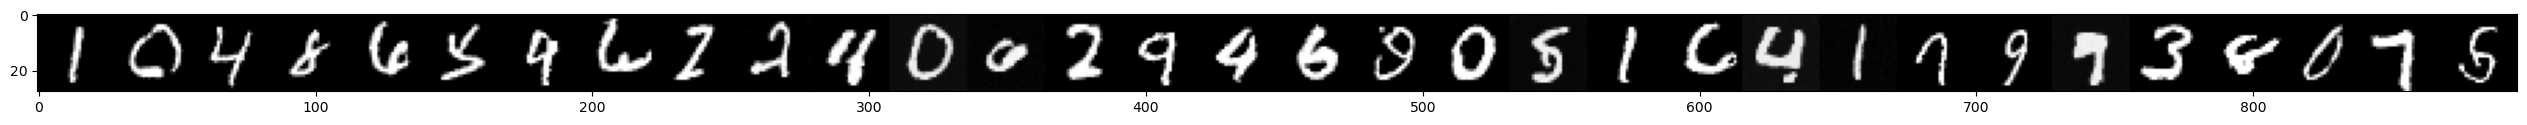

 19%|██████████████▎                                                            | 19/100 [2:20:53<10:09:57, 451.83s/it]

Epoch [19/100] | Train Loss: 0.0230 | Validation Loss: 0.0228


 20%|███████████████▏                                                            | 20/100 [2:27:53<9:49:58, 442.48s/it]

Epoch [20/100] | Train Loss: 0.0227 | Validation Loss: 0.0226


 21%|███████████████▉                                                            | 21/100 [2:34:53<9:33:30, 435.58s/it]

Epoch [21/100] | Train Loss: 0.0230 | Validation Loss: 0.0222


999it [01:09, 14.33it/s]


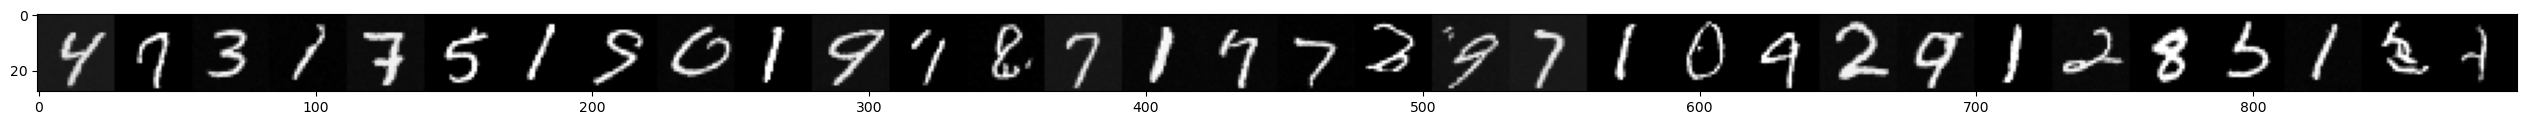

 22%|████████████████▋                                                           | 22/100 [2:43:00<9:46:17, 451.00s/it]

Epoch [22/100] | Train Loss: 0.0226 | Validation Loss: 0.0230


 23%|█████████████████▍                                                          | 23/100 [2:49:57<9:25:44, 440.84s/it]

Epoch [23/100] | Train Loss: 0.0224 | Validation Loss: 0.0222


 24%|██████████████████▏                                                         | 24/100 [2:56:54<9:09:29, 433.80s/it]

Epoch [24/100] | Train Loss: 0.0224 | Validation Loss: 0.0225


999it [01:09, 14.29it/s]


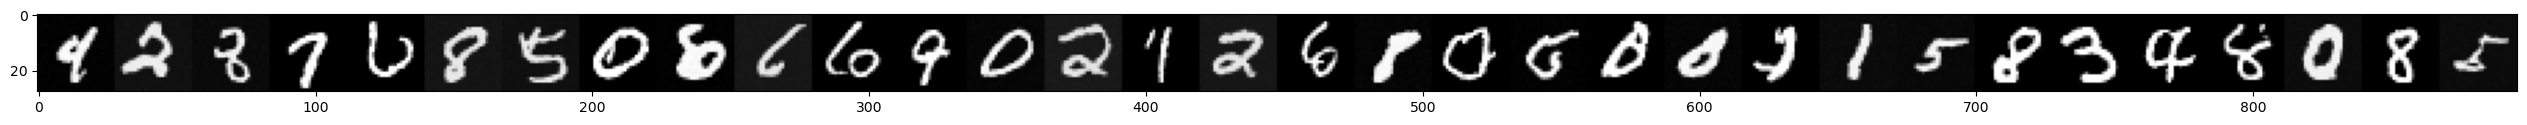

 25%|███████████████████                                                         | 25/100 [3:05:02<9:22:33, 450.05s/it]

Epoch [25/100] | Train Loss: 0.0226 | Validation Loss: 0.0221


 26%|███████████████████▊                                                        | 26/100 [3:11:59<9:02:46, 440.09s/it]

Epoch [26/100] | Train Loss: 0.0224 | Validation Loss: 0.0221


 27%|████████████████████▌                                                       | 27/100 [3:18:56<8:46:51, 433.03s/it]

Epoch [27/100] | Train Loss: 0.0223 | Validation Loss: 0.0219


999it [01:09, 14.34it/s]


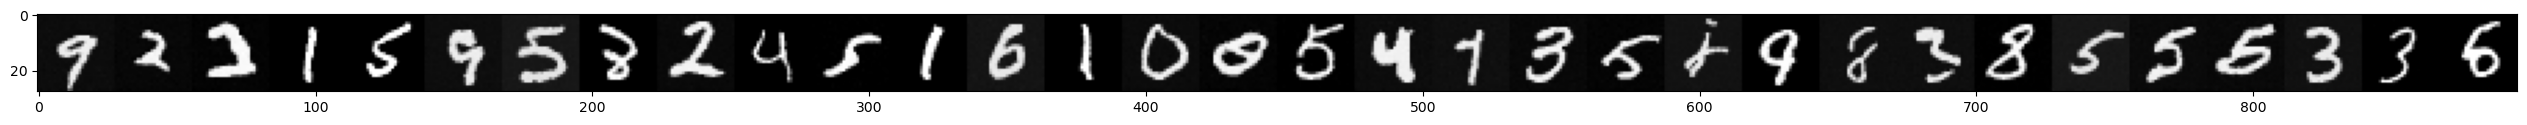

 28%|█████████████████████▎                                                      | 28/100 [3:27:01<8:58:34, 448.81s/it]

Epoch [28/100] | Train Loss: 0.0225 | Validation Loss: 0.0223


 29%|██████████████████████                                                      | 29/100 [3:33:57<8:39:24, 438.94s/it]

Epoch [29/100] | Train Loss: 0.0222 | Validation Loss: 0.0222


 30%|██████████████████████▊                                                     | 30/100 [3:40:53<8:24:02, 432.03s/it]

Epoch [30/100] | Train Loss: 0.0221 | Validation Loss: 0.0223


999it [01:09, 14.38it/s]


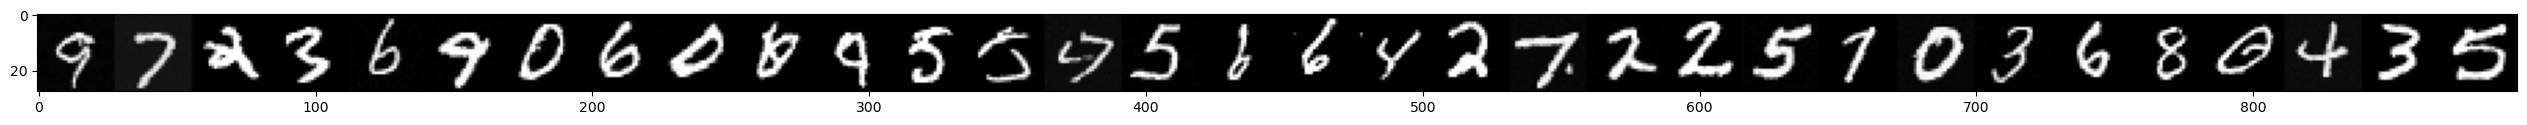

 31%|███████████████████████▌                                                    | 31/100 [3:48:59<8:35:16, 448.07s/it]

Epoch [31/100] | Train Loss: 0.0222 | Validation Loss: 0.0223


 32%|████████████████████████▎                                                   | 32/100 [3:55:55<8:16:58, 438.51s/it]

Epoch [32/100] | Train Loss: 0.0221 | Validation Loss: 0.0223


 33%|█████████████████████████                                                   | 33/100 [4:02:51<8:02:01, 431.67s/it]

Epoch [33/100] | Train Loss: 0.0220 | Validation Loss: 0.0220


999it [01:09, 14.38it/s]


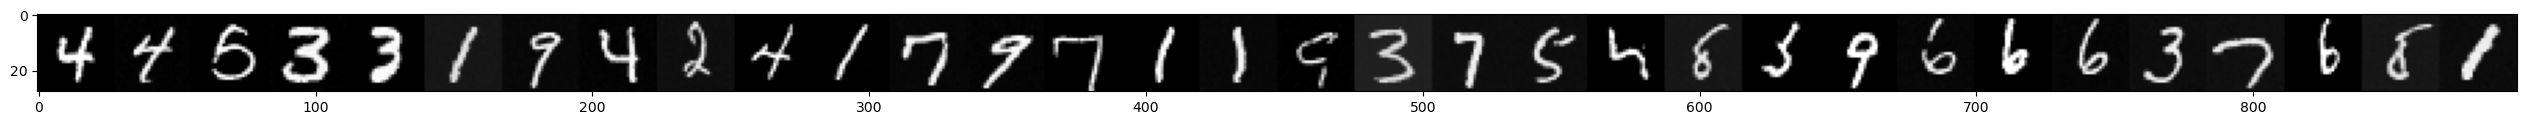

 34%|█████████████████████████▊                                                  | 34/100 [4:10:56<8:12:32, 447.77s/it]

Epoch [34/100] | Train Loss: 0.0220 | Validation Loss: 0.0222


 35%|██████████████████████████▌                                                 | 35/100 [4:17:51<7:54:34, 438.07s/it]

Epoch [35/100] | Train Loss: 0.0219 | Validation Loss: 0.0215


 36%|███████████████████████████▎                                                | 36/100 [4:24:47<7:39:56, 431.19s/it]

Epoch [36/100] | Train Loss: 0.0220 | Validation Loss: 0.0218


999it [01:09, 14.39it/s]


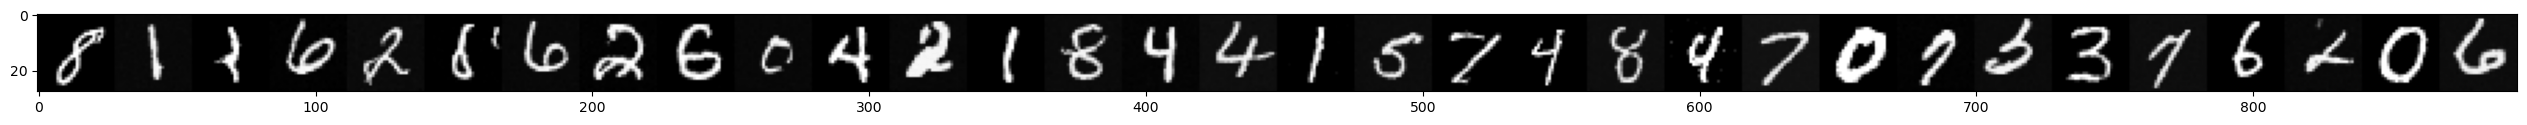

 37%|████████████████████████████                                                | 37/100 [4:32:52<7:49:41, 447.33s/it]

Epoch [37/100] | Train Loss: 0.0218 | Validation Loss: 0.0219


 38%|████████████████████████████▉                                               | 38/100 [4:39:45<7:31:48, 437.23s/it]

Epoch [38/100] | Train Loss: 0.0219 | Validation Loss: 0.0216


 39%|█████████████████████████████▋                                              | 39/100 [4:46:39<7:17:16, 430.11s/it]

Epoch [39/100] | Train Loss: 0.0218 | Validation Loss: 0.0220


999it [01:09, 14.45it/s]


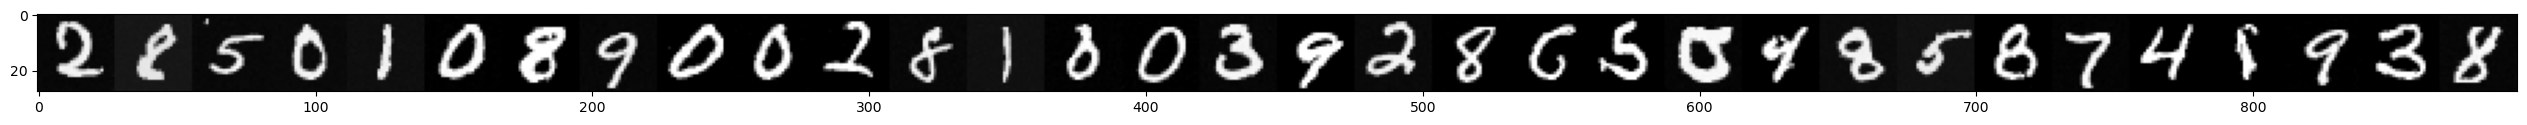

 40%|██████████████████████████████▍                                             | 40/100 [4:54:42<7:25:59, 445.99s/it]

Epoch [40/100] | Train Loss: 0.0219 | Validation Loss: 0.0214


 41%|███████████████████████████████▏                                            | 41/100 [5:01:35<7:08:58, 436.24s/it]

Epoch [41/100] | Train Loss: 0.0217 | Validation Loss: 0.0218


 42%|███████████████████████████████▉                                            | 42/100 [5:08:29<6:55:06, 429.43s/it]

Epoch [42/100] | Train Loss: 0.0218 | Validation Loss: 0.0216


999it [01:09, 14.43it/s]


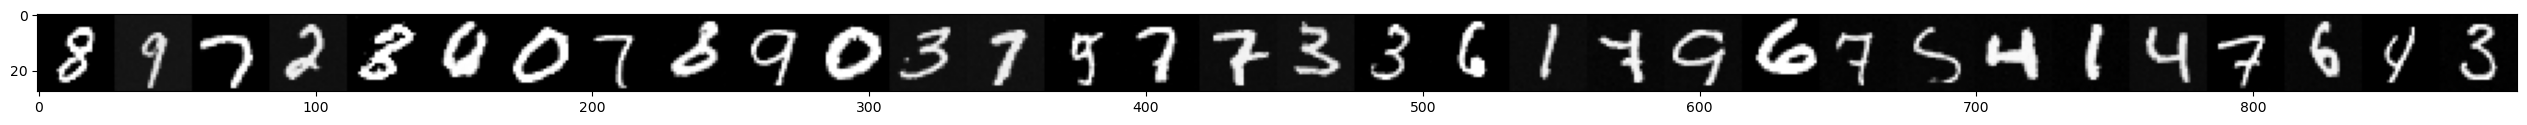

 43%|████████████████████████████████▋                                           | 43/100 [5:16:32<7:03:11, 445.46s/it]

Epoch [43/100] | Train Loss: 0.0217 | Validation Loss: 0.0215


 44%|█████████████████████████████████▍                                          | 44/100 [5:23:25<6:46:51, 435.93s/it]

Epoch [44/100] | Train Loss: 0.0215 | Validation Loss: 0.0218


 45%|██████████████████████████████████▏                                         | 45/100 [5:30:19<6:33:29, 429.26s/it]

Epoch [45/100] | Train Loss: 0.0216 | Validation Loss: 0.0208


999it [01:09, 14.42it/s]


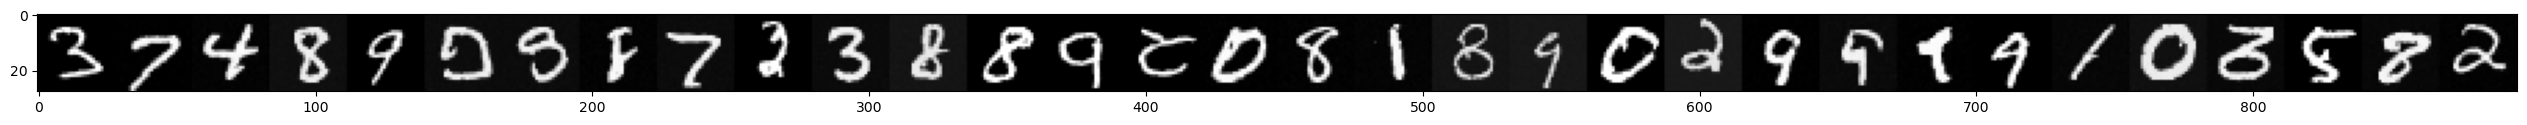

 46%|██████████████████████████████████▉                                         | 46/100 [5:38:22<6:40:48, 445.35s/it]

Epoch [46/100] | Train Loss: 0.0216 | Validation Loss: 0.0216


 47%|███████████████████████████████████▋                                        | 47/100 [5:45:16<6:24:58, 435.83s/it]

Epoch [47/100] | Train Loss: 0.0215 | Validation Loss: 0.0218


 48%|████████████████████████████████████▍                                       | 48/100 [5:52:09<6:11:55, 429.14s/it]

Epoch [48/100] | Train Loss: 0.0217 | Validation Loss: 0.0217


999it [01:09, 14.43it/s]


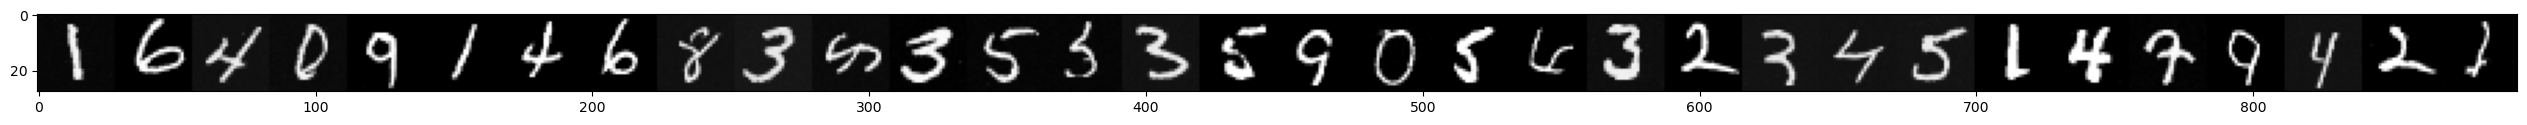

 49%|█████████████████████████████████████▏                                      | 49/100 [6:00:12<6:18:28, 445.27s/it]

Epoch [49/100] | Train Loss: 0.0214 | Validation Loss: 0.0214


 50%|██████████████████████████████████████                                      | 50/100 [6:07:06<6:03:08, 435.77s/it]

Epoch [50/100] | Train Loss: 0.0216 | Validation Loss: 0.0216


 51%|██████████████████████████████████████▊                                     | 51/100 [6:13:59<5:50:28, 429.15s/it]

Epoch [51/100] | Train Loss: 0.0214 | Validation Loss: 0.0214


999it [01:09, 14.43it/s]


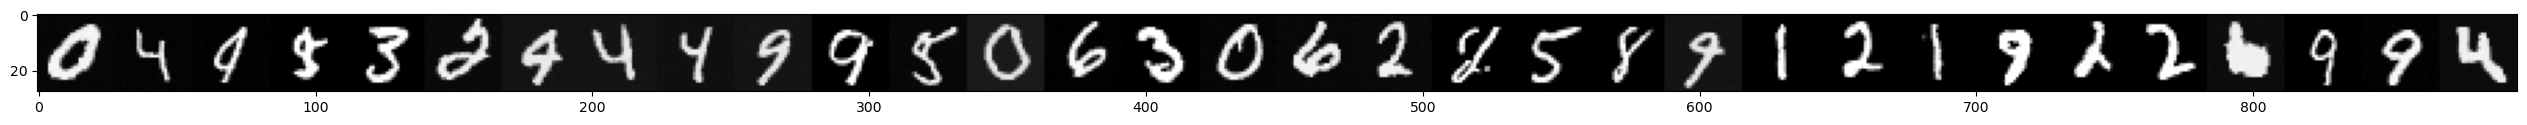

 52%|███████████████████████████████████████▌                                    | 52/100 [6:22:02<5:56:15, 445.32s/it]

Epoch [52/100] | Train Loss: 0.0217 | Validation Loss: 0.0212


 53%|████████████████████████████████████████▎                                   | 53/100 [6:28:56<5:41:24, 435.83s/it]

Epoch [53/100] | Train Loss: 0.0215 | Validation Loss: 0.0215


 54%|█████████████████████████████████████████                                   | 54/100 [6:35:50<5:29:00, 429.15s/it]

Epoch [54/100] | Train Loss: 0.0215 | Validation Loss: 0.0214


999it [01:09, 14.43it/s]


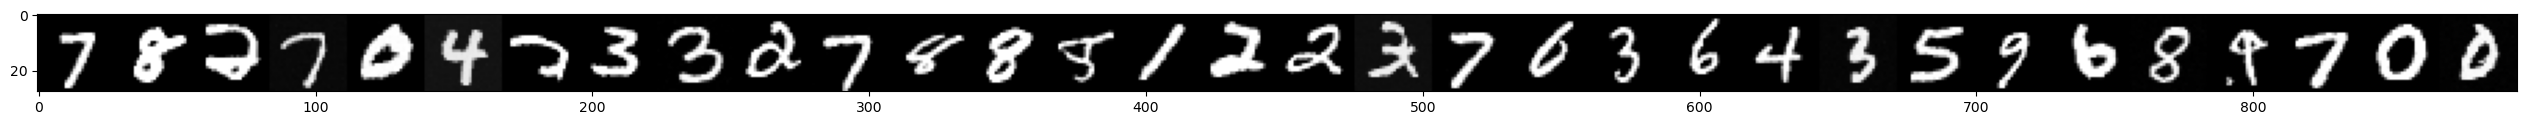

 55%|█████████████████████████████████████████▊                                  | 55/100 [6:43:53<5:33:57, 445.27s/it]

Epoch [55/100] | Train Loss: 0.0214 | Validation Loss: 0.0213


 56%|██████████████████████████████████████████▌                                 | 56/100 [6:50:46<5:19:36, 435.83s/it]

Epoch [56/100] | Train Loss: 0.0214 | Validation Loss: 0.0217


 57%|███████████████████████████████████████████▎                                | 57/100 [6:57:41<5:07:49, 429.53s/it]

Epoch [57/100] | Train Loss: 0.0212 | Validation Loss: 0.0213


999it [01:09, 14.41it/s]


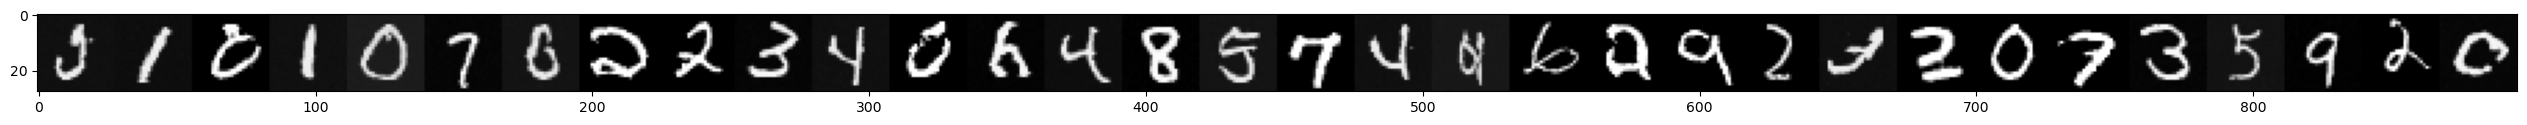

 58%|████████████████████████████████████████████                                | 58/100 [7:05:45<5:11:58, 445.68s/it]

Epoch [58/100] | Train Loss: 0.0213 | Validation Loss: 0.0211


 59%|████████████████████████████████████████████▊                               | 59/100 [7:12:40<4:58:26, 436.75s/it]

Epoch [59/100] | Train Loss: 0.0213 | Validation Loss: 0.0208


 60%|█████████████████████████████████████████████▌                              | 60/100 [7:19:34<4:46:33, 429.84s/it]

Epoch [60/100] | Train Loss: 0.0213 | Validation Loss: 0.0210


999it [01:09, 14.43it/s]


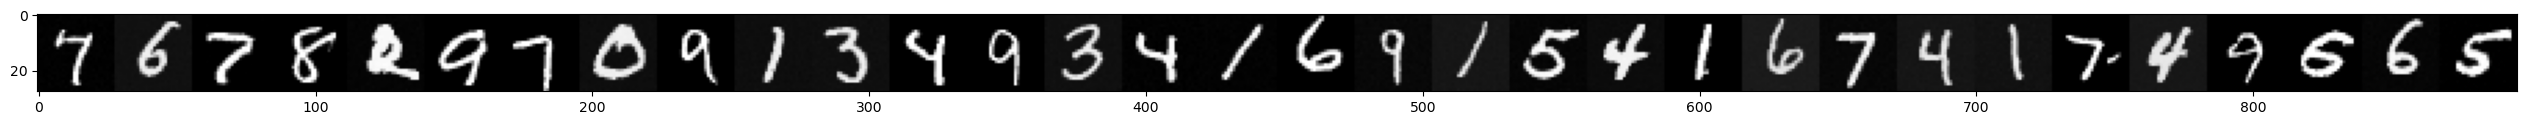

 61%|██████████████████████████████████████████████▎                             | 61/100 [7:27:37<4:49:43, 445.73s/it]

Epoch [61/100] | Train Loss: 0.0214 | Validation Loss: 0.0209


 62%|███████████████████████████████████████████████                             | 62/100 [7:34:31<4:36:11, 436.10s/it]

Epoch [62/100] | Train Loss: 0.0214 | Validation Loss: 0.0217


 63%|███████████████████████████████████████████████▉                            | 63/100 [7:41:24<4:24:48, 429.42s/it]

Epoch [63/100] | Train Loss: 0.0213 | Validation Loss: 0.0211


999it [01:09, 14.45it/s]


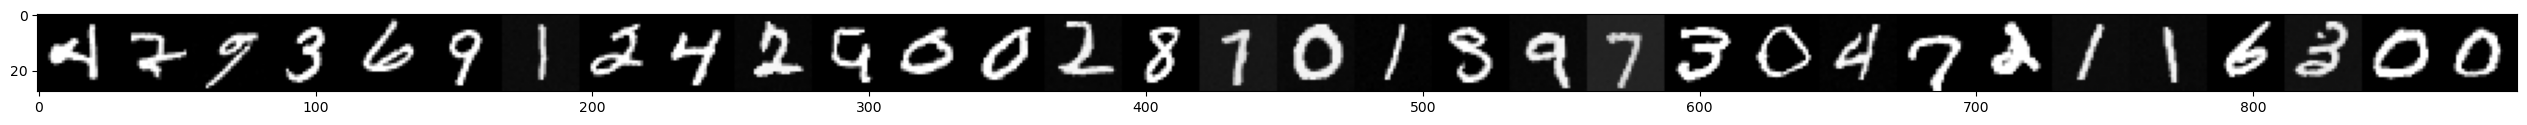

 64%|████████████████████████████████████████████████▋                           | 64/100 [7:49:27<4:27:16, 445.47s/it]

Epoch [64/100] | Train Loss: 0.0214 | Validation Loss: 0.0213


 65%|█████████████████████████████████████████████████▍                          | 65/100 [7:56:21<4:14:15, 435.88s/it]

Epoch [65/100] | Train Loss: 0.0214 | Validation Loss: 0.0211


 66%|██████████████████████████████████████████████████▏                         | 66/100 [8:03:14<4:03:10, 429.12s/it]

Epoch [66/100] | Train Loss: 0.0212 | Validation Loss: 0.0207


999it [01:09, 14.46it/s]


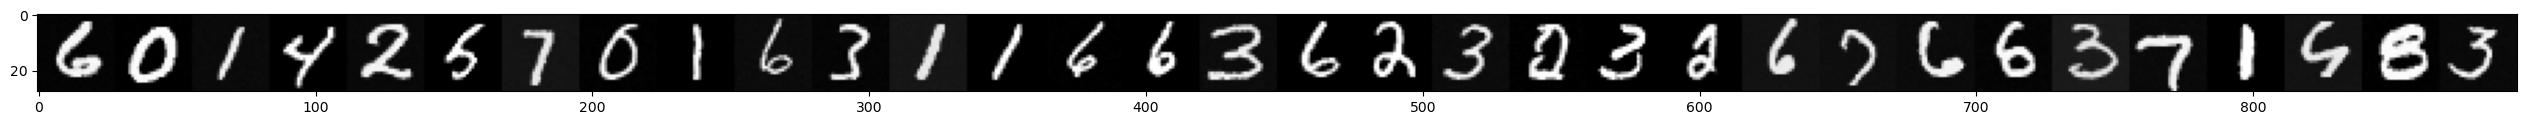

 67%|██████████████████████████████████████████████████▉                         | 67/100 [8:11:17<4:04:50, 445.18s/it]

Epoch [67/100] | Train Loss: 0.0213 | Validation Loss: 0.0207


 68%|███████████████████████████████████████████████████▋                        | 68/100 [8:18:10<3:52:20, 435.66s/it]

Epoch [68/100] | Train Loss: 0.0213 | Validation Loss: 0.0210


 69%|████████████████████████████████████████████████████▍                       | 69/100 [8:25:04<3:41:38, 428.99s/it]

Epoch [69/100] | Train Loss: 0.0212 | Validation Loss: 0.0210


999it [01:09, 14.42it/s]


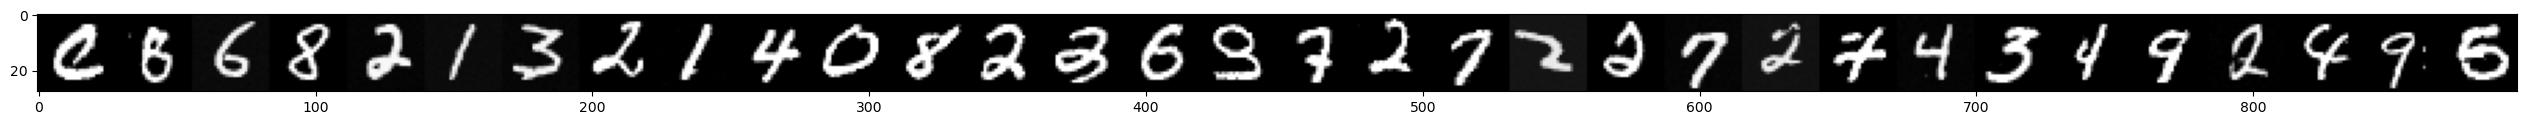

 70%|█████████████████████████████████████████████████████▏                      | 70/100 [8:33:06<3:42:33, 445.10s/it]

Epoch [70/100] | Train Loss: 0.0214 | Validation Loss: 0.0212


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [8:40:00<3:30:29, 435.51s/it]

Epoch [71/100] | Train Loss: 0.0211 | Validation Loss: 0.0214


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [8:46:53<3:20:09, 428.90s/it]

Epoch [72/100] | Train Loss: 0.0213 | Validation Loss: 0.0210


999it [01:09, 14.44it/s]


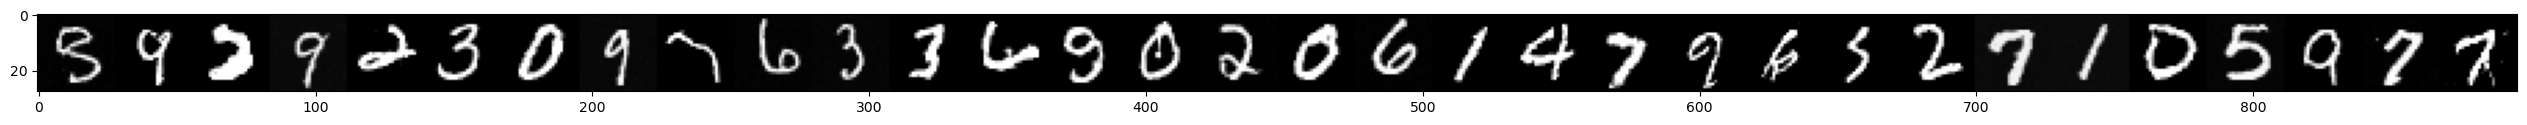

 73%|███████████████████████████████████████████████████████▍                    | 73/100 [8:54:56<3:20:15, 445.03s/it]

Epoch [73/100] | Train Loss: 0.0214 | Validation Loss: 0.0211


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [9:01:49<3:08:43, 435.50s/it]

Epoch [74/100] | Train Loss: 0.0212 | Validation Loss: 0.0210


 75%|█████████████████████████████████████████████████████████                   | 75/100 [9:08:42<2:58:41, 428.86s/it]

Epoch [75/100] | Train Loss: 0.0212 | Validation Loss: 0.0219


999it [01:09, 14.42it/s]


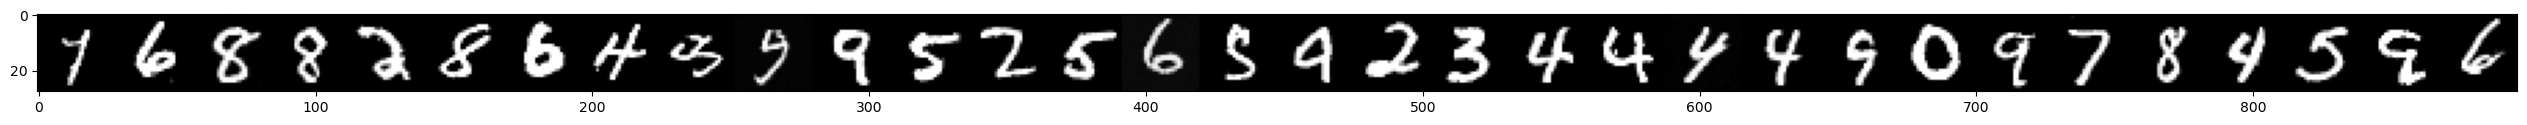

 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [9:16:46<2:58:05, 445.22s/it]

Epoch [76/100] | Train Loss: 0.0213 | Validation Loss: 0.0213


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [9:23:39<2:46:58, 435.60s/it]

Epoch [77/100] | Train Loss: 0.0213 | Validation Loss: 0.0213


 78%|███████████████████████████████████████████████████████████▎                | 78/100 [9:30:32<2:37:13, 428.78s/it]

Epoch [78/100] | Train Loss: 0.0212 | Validation Loss: 0.0206


999it [01:09, 14.42it/s]


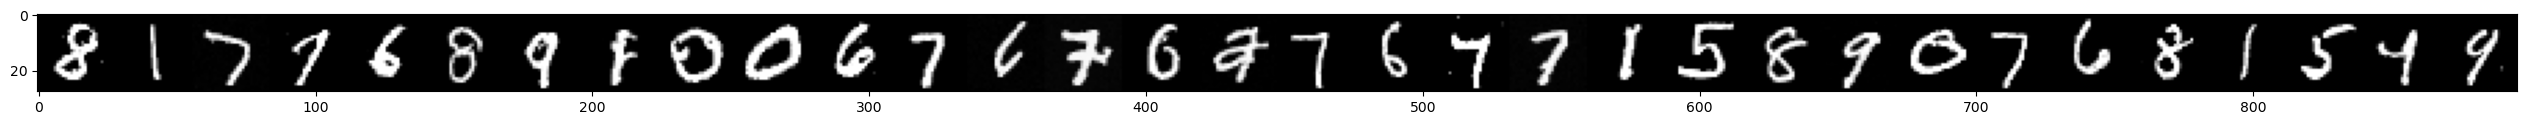

 79%|████████████████████████████████████████████████████████████                | 79/100 [9:38:36<2:35:52, 445.34s/it]

Epoch [79/100] | Train Loss: 0.0213 | Validation Loss: 0.0210


 80%|████████████████████████████████████████████████████████████▊               | 80/100 [9:45:31<2:25:28, 436.40s/it]

Epoch [80/100] | Train Loss: 0.0211 | Validation Loss: 0.0215


 81%|█████████████████████████████████████████████████████████████▌              | 81/100 [9:52:27<2:16:15, 430.27s/it]

Epoch [81/100] | Train Loss: 0.0213 | Validation Loss: 0.0214


999it [01:09, 14.36it/s]


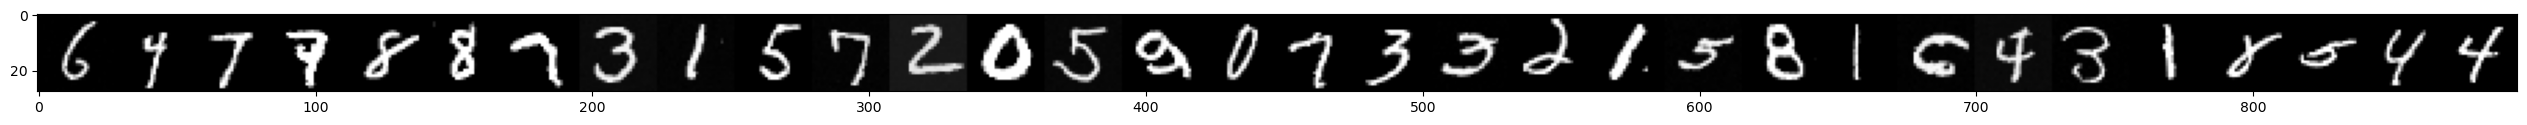

 82%|█████████████████████████████████████████████████████████████▍             | 82/100 [10:00:33<2:14:02, 446.80s/it]

Epoch [82/100] | Train Loss: 0.0210 | Validation Loss: 0.0211


 83%|██████████████████████████████████████████████████████████████▎            | 83/100 [10:07:26<2:03:46, 436.84s/it]

Epoch [83/100] | Train Loss: 0.0212 | Validation Loss: 0.0208


 84%|███████████████████████████████████████████████████████████████            | 84/100 [10:14:20<1:54:36, 429.80s/it]

Epoch [84/100] | Train Loss: 0.0212 | Validation Loss: 0.0210


999it [01:09, 14.42it/s]


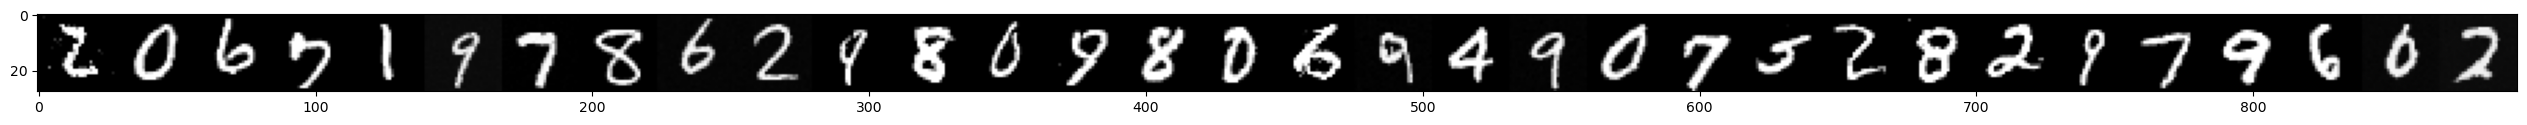

 85%|███████████████████████████████████████████████████████████████▊           | 85/100 [10:22:23<1:51:27, 445.83s/it]

Epoch [85/100] | Train Loss: 0.0211 | Validation Loss: 0.0214


 86%|████████████████████████████████████████████████████████████████▌          | 86/100 [10:29:17<1:41:47, 436.25s/it]

Epoch [86/100] | Train Loss: 0.0212 | Validation Loss: 0.0212


 87%|█████████████████████████████████████████████████████████████████▎         | 87/100 [10:36:11<1:33:03, 429.53s/it]

Epoch [87/100] | Train Loss: 0.0211 | Validation Loss: 0.0209


999it [01:09, 14.41it/s]


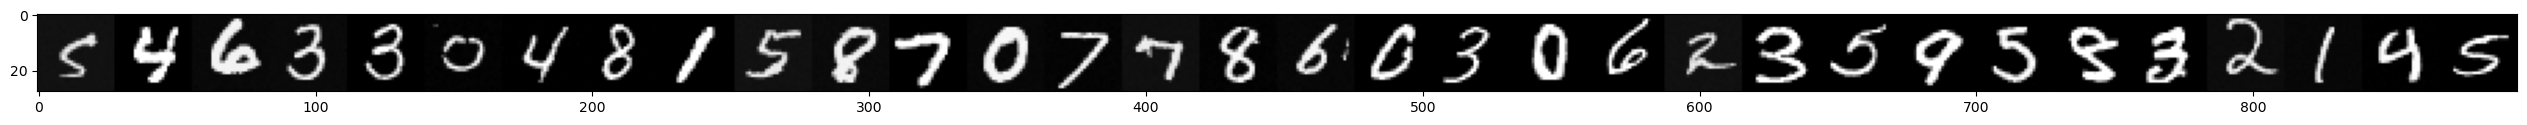

 88%|██████████████████████████████████████████████████████████████████         | 88/100 [10:44:14<1:29:07, 445.65s/it]

Epoch [88/100] | Train Loss: 0.0212 | Validation Loss: 0.0208


 89%|██████████████████████████████████████████████████████████████████▊        | 89/100 [10:51:08<1:19:57, 436.13s/it]

Epoch [89/100] | Train Loss: 0.0212 | Validation Loss: 0.0211


 90%|███████████████████████████████████████████████████████████████████▌       | 90/100 [10:58:01<1:11:33, 429.35s/it]

Epoch [90/100] | Train Loss: 0.0210 | Validation Loss: 0.0214


999it [01:09, 14.41it/s]


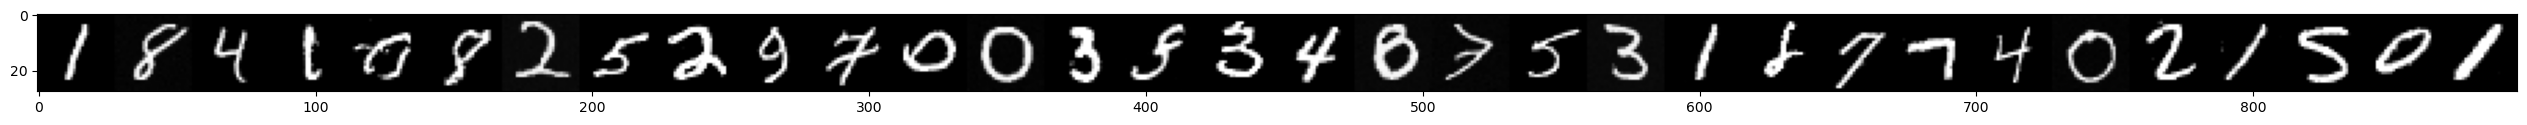

 91%|████████████████████████████████████████████████████████████████████▎      | 91/100 [11:06:04<1:06:49, 445.45s/it]

Epoch [91/100] | Train Loss: 0.0211 | Validation Loss: 0.0210


 92%|██████████████████████████████████████████████████████████████████████▊      | 92/100 [11:12:58<58:07, 435.90s/it]

Epoch [92/100] | Train Loss: 0.0211 | Validation Loss: 0.0210


 93%|███████████████████████████████████████████████████████████████████████▌     | 93/100 [11:19:51<50:04, 429.19s/it]

Epoch [93/100] | Train Loss: 0.0210 | Validation Loss: 0.0207


999it [01:09, 14.43it/s]


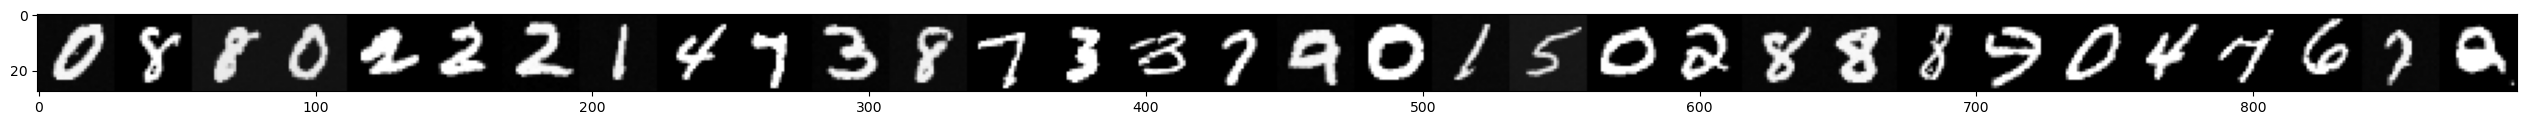

 94%|████████████████████████████████████████████████████████████████████████▍    | 94/100 [11:27:54<44:31, 445.30s/it]

Epoch [94/100] | Train Loss: 0.0210 | Validation Loss: 0.0212


 95%|█████████████████████████████████████████████████████████████████████████▏   | 95/100 [11:34:48<36:18, 435.73s/it]

Epoch [95/100] | Train Loss: 0.0212 | Validation Loss: 0.0206


 96%|█████████████████████████████████████████████████████████████████████████▉   | 96/100 [11:41:41<28:36, 429.11s/it]

Epoch [96/100] | Train Loss: 0.0209 | Validation Loss: 0.0210


999it [01:09, 14.42it/s]


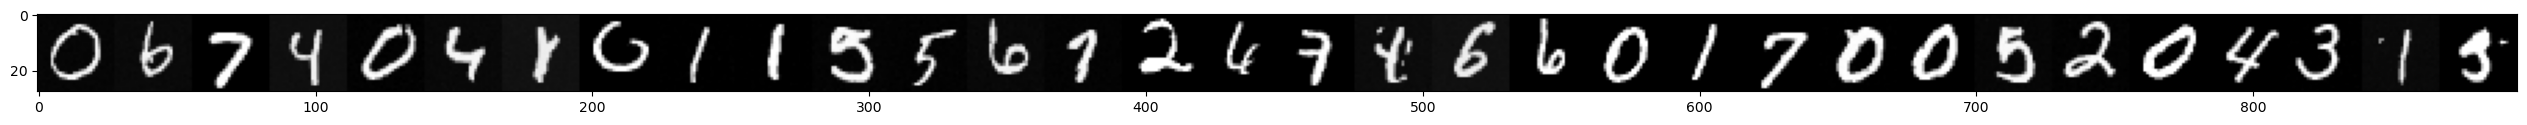

 97%|██████████████████████████████████████████████████████████████████████████▋  | 97/100 [11:49:44<22:15, 445.25s/it]

Epoch [97/100] | Train Loss: 0.0211 | Validation Loss: 0.0212


 98%|███████████████████████████████████████████████████████████████████████████▍ | 98/100 [11:56:38<14:31, 435.72s/it]

Epoch [98/100] | Train Loss: 0.0210 | Validation Loss: 0.0216


 99%|████████████████████████████████████████████████████████████████████████████▏| 99/100 [12:03:31<07:09, 429.01s/it]

Epoch [99/100] | Train Loss: 0.0210 | Validation Loss: 0.0210


999it [01:09, 14.44it/s]


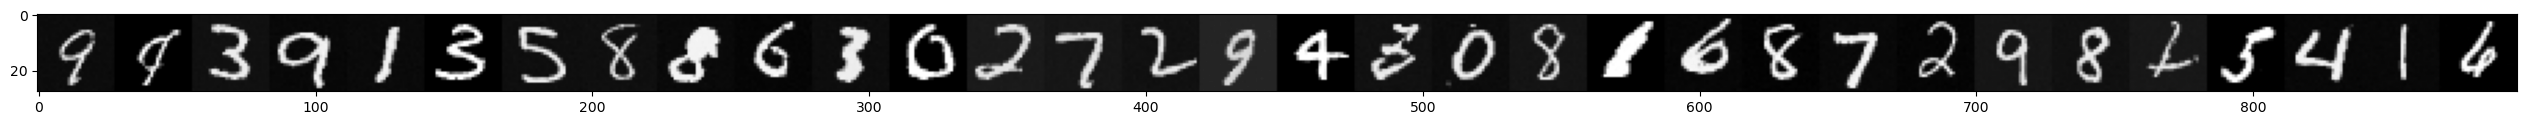

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [12:11:34<00:00, 438.94s/it]

Epoch [100/100] | Train Loss: 0.0212 | Validation Loss: 0.0213


In [53]:
EPOCHS = 100
batch_size = 64
image_size = 28
learning_rate = 3e-4

# Import dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
diffusion = Diffusion(img_size=image_size, device=device)
length = len(train_loader)
print(length)

train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x, t)
        
        predicted_noise = model(x_t, t)
        loss = loss_fn(noise, predicted_noise)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for x, _ in val_loader:
            #print(type(x))
            #print(x.shape)
            x = x.to(device)
            t = diffusion.sample_timesteps(x.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(x, t)
            predicted_noise = model(x_t, t)
            batch_val_loss = loss_fn(noise, predicted_noise)
            val_loss += batch_val_loss.item()
    
    # Sample only every 3 epochs for opt purposes
    if epoch%3 == 0:
        sampled_images = diffusion.sample(model, n=x.shape[0])
        plot_images(sampled_images)
        
    # Save loss
    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    print(f"Epoch [{epoch+1}/100] | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

In [39]:
# Manually create loss record since I forgot to add the append.
train_losses = []
val_losses = []

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,

In [54]:
### Save model
torch.save(model.state_dict(), './Models/DM/diffusion2')

### FID

In [38]:
from inception import InceptionV3
from torchvision.utils import save_image
from torchvision.models import inception_v3
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm


def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1-mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1+sigma2- 2*covmean)
    return fid

def get_activations(images, model, batch_size=32, dims=2048, device='cuda'):
    model.eval()
    pred_arr = np.empty((len(images), dims))
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            start = i
            end = i+batch_size
            batch = images[start:end].to(device)
            #print(batch.size())
            #raise
            pred = model(batch)[0]
            pred = F.adaptive_avg_pool2d(pred, output_size=(1,1))
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr[start:end] = pred
    return pred_arr

#inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
#inception_model.fc = torch.nn.Identity()
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

In [40]:
original_images = []
generated_images = []

model.eval()
with torch.no_grad():
    for x, t in train_loader:
        original_images.append(x)
        sampled = diffusion.sample(model, n=x.shape[0])
        generated_images.append(sampled)
        
original_images = torch.stack(original_images)
generated_images = torch.stack(generated_images)

999it [01:06, 14.93it/s]
999it [01:07, 14.79it/s]
999it [01:08, 14.60it/s]
999it [01:08, 14.67it/s]
999it [01:09, 14.44it/s]
999it [01:08, 14.52it/s]
999it [01:09, 14.33it/s]
999it [01:09, 14.46it/s]
999it [01:08, 14.56it/s]
999it [01:09, 14.27it/s]
999it [01:08, 14.55it/s]
999it [01:09, 14.37it/s]
999it [01:08, 14.57it/s]
999it [01:09, 14.39it/s]
999it [01:08, 14.56it/s]
999it [01:11, 13.98it/s]
999it [01:09, 14.41it/s]
999it [01:08, 14.66it/s]
999it [01:07, 14.71it/s]
999it [01:09, 14.32it/s]
999it [01:08, 14.60it/s]
999it [01:08, 14.58it/s]
999it [01:08, 14.55it/s]
999it [01:09, 14.36it/s]
999it [01:08, 14.49it/s]
999it [01:09, 14.39it/s]
999it [01:08, 14.53it/s]
999it [01:10, 14.13it/s]
999it [01:10, 14.15it/s]
999it [01:09, 14.46it/s]
999it [01:10, 14.16it/s]
999it [01:11, 13.98it/s]
999it [01:13, 13.59it/s]
999it [01:15, 13.22it/s]
999it [01:11, 13.94it/s]
999it [01:11, 14.01it/s]
999it [01:11, 13.89it/s]
999it [01:10, 14.09it/s]
999it [01:09, 14.30it/s]
999it [01:08, 14.50it/s]


KeyboardInterrupt: 

In [49]:
generated_images.size()

torch.Size([111, 32, 1, 28, 28])

In [52]:
original_images = torch.stack(original_images[:-1])
generated_images = torch.stack(generated_images)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [54]:
transform = torchvision.transforms.Compose([
    #transforms.Grayscale(3)
    torchvision.transforms.Lambda(lambda x: x.repeat(1, 1, 3, 1, 1))
])

original_transformed = []
generated_transformed = []

for i in range(len(generated_images)):
    original_transformed.append(transform(original_images[i].squeeze()))
    generated_transformed.append(transform(generated_images[i].squeeze()))
    
original_transformed = torch.stack(original_transformed)
generated_transformed = torch.stack(generated_transformed)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [50]:
generated_transformed.size()

torch.Size([111, 96, 28, 28])

In [47]:
generated_transformed = generated_transformed/255 - 1

In [48]:
import numpy as np

original_activations = get_activations(original_transformed, inception_model, device=device)
generated_activations = get_activations(generated_transformed, inception_model, device=device)

# Calculate mean and covariance of the activations
mu1 = np.mean(original_activations, axis=0)
sigma1 = np.cov(original_activations, rowvar=False)
mu2 = np.mean(generated_activations, axis=0)
sigma2 = np.cov(generated_activations, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print('FID score:', fid_score)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 96, 299, 299] to have 3 channels, but got 96 channels instead